## Pix2Pix CGAN on MNIST

In [1]:
# Imports 
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm


In [2]:
# GLOBAL VARIABLE
DATA_PATH = './data'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=128
NUM_WORKERS=2
IMAGE_SIZE=256
CHANNELS_IMG=1
LEARNING_RATE = 2e-4
L1_LAMBDA = 100
NUM_EPOCHS = 200
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPIONT_DISC = 'disc.pth.tar'
CHECKPOINT_GEN = 'gen.pth.tar'


### Discriminator

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, padding=1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        return self.conv(x)
    

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]): # 256x256 input -> 30x30 outputs
        super(Discriminator, self).__init__()
        # Initial Block
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels * 2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        
        # Create 4 CNN Blocks 
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(CNNBlock(in_channels, feature, stride = 1 if feature == features[-1] else 2)) # 1x1 stride for last layer
            in_channels = feature       
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1) # concatennate the input and target images along the channel dimension
        x = self.initial(x)
        return self.model(x)
        
            

In [4]:
# Test the Discriminator model
x = torch.rand((1, 3, 256, 256))
y = torch.rand((1, 3, 256, 256))
model = Discriminator(3)
model(x, y).shape

torch.Size([1, 1, 30, 30])

### Generator

In [5]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, activation="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect") if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if activation == "relu" else nn.LeakyReLU(0.2)
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x
    
    
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super(Generator, self).__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        
        # Down Sampling; encoder part of the generator
        self.down1 = Block(features, features*2, down=True, activation="leaky", use_dropout=False)      # 64
        self.down2 = Block(features*2, features*4, down=True, activation="leaky", use_dropout=False)    # 32
        self.down3 = Block(features*4, features*8, down=True, activation="leaky", use_dropout=False)    # 16
        self.down4 = Block(features*8, features*8, down=True, activation="leaky", use_dropout=False)    # 8
        self.down5 = Block(features*8, features*8, down=True, activation="leaky", use_dropout=False)    # 4
        self.down6 = Block(features*8, features*8, down=True, activation="leaky", use_dropout=False)    # 2
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode="reflect"),                         # 1
            nn.ReLU()
        )
        # Up Sampling; decoder part of the generator
        self.up1 = Block(features*8, features*8, down=False, activation="relu", use_dropout=True)       # 2
        self.up2 = Block(features*8*2, features*8, down=False, activation="relu", use_dropout=True)     # 4
        self.up3 = Block(features*8*2, features*8, down=False, activation="relu", use_dropout=True)     # 8
        self.up4 = Block(features*8*2, features*8, down=False, activation="relu", use_dropout=False)    # 16
        self.up5 = Block(features*8*2, features*4, down=False, activation="relu", use_dropout=False)    # 32
        self.up6 = Block(features*4*2, features*2, down=False, activation="relu", use_dropout=False)    # 64
        self.up7 = Block(features*2*2, features, down=False, activation="relu", use_dropout=False)      # 128
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),            #256
            nn.Tanh(), # Normalize the image pixels between -1 and 1
        )
        
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [6]:
# Test the Generator model
x = torch.rand((1, 3, 256, 256))
model = Generator(in_channels=3, features=64)
preds = model(x)
print(preds.shape)

torch.Size([1, 3, 256, 256])


### Dataset

In [7]:
# Define the Transformations
both_transform = A.Compose(
    [A.Resize(width=256, height=256)],
    additional_targets={'image0': 'image'}
)

transform_only_input = A.Compose(
    [    
     A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
    ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
    ToTensorV2(),
    ]
)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [8]:
class MNistDataset(Dataset):
    def __init__(self, root=DATA_PATH, transform=None):
        # Download the MNIST dataset to ./data
        dataset = datasets.MNIST(root=root,
                                download=True,
                                transform=transform
                                )
        reduced_dataset_size = 1000
        indices = np.random.choice(len(dataset), reduced_dataset_size, replace=False)
        self.dataset = Subset(dataset, indices)
        self.odd_sample_images = {}
        # collect sample images of odd digits from the dataset, break once we have 1 sample for each odd digit
        for i, (image, label) in enumerate(self.dataset):
            if label % 2 != 0 and label not in self.odd_sample_images:
                self.odd_sample_images[label] = image
            if len(self.odd_sample_images) == 5:
                break
        
    def find_target_image(self, target_label):
        # Find the image in the dataset with the target label
        for i, (image, label) in enumerate(self.dataset):
            if label == target_label:
                return image
        return None
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        input_image = self.dataset[index][0]
        target_image = self.dataset[index][0]
        # if the input_image is an even digit, the target image is input_image + 1
        if self.dataset[index][1] % 2 == 0:
            target_label = self.dataset[index][1] + 1
            target_image = self.odd_sample_images[target_label]
        else:
            target_label = self.dataset[index][1]
        # target_image = self.find_target_image(target_label)
        
        return input_image, target_image


### Train

In [9]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpiont...")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoing...")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    # avoid optimizer having older checkpoint learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        

def save_some_exmaples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5 # remove normalization
        save_image(y_fake, folder + f"\y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/target_{epoch}.png")
    gen.train()

In [10]:
def train(disc, gen, loader, opt_disc, opt_gen, l1, bce, g_scaler, d_scaler):
    # main training loop of the CGAN
    loop = tqdm(loader, leave=True)
    gen_loss = []
    disc_loss = []
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        # Train the discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_fake = disc(x, y_fake.detach()) # detach the generator output to avoid backpropagation through the generator
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2
        
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        # Train the generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1
            
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        disc_loss.append(D_loss)
        gen_loss.append(G_loss)
        
    return disc_loss, gen_loss
            

In [13]:
# Initialize the Models
disc = Discriminator(in_channels=1).to(DEVICE)
gen = Generator(in_channels=1, features=64).to(DEVICE)

# Initialize the optimizers
opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Define the loss functions
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

# Create a dataloader from the modified MNIST dataset
mnist_dataset = MNistDataset(root=DATA_PATH, transform=transform)
train_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(mnist_dataset, batch_size=1, shuffle=True)

if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
    load_checkpoint(CHECKPIONT_DISC, disc, opt_disc, LEARNING_RATE)

In [14]:
D_losses = []
G_losses = []
print(f"Start Training on {DEVICE}...")
for epoch in range(NUM_EPOCHS):
    d_loss, g_loss = train(disc, gen, train_dataloader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
    # Calculate the average loss for the epoch
    D_losses.append(sum(d_loss)/len(d_loss))
    G_losses.append(sum(g_loss)/len(g_loss))
    print(f"Epoch [{epoch}/{NUM_EPOCHS}] Loss D: {D_losses[-1]:.4f}, Loss G: {G_losses[-1]:.4f}")
    
    if SAVE_MODEL and epoch % 5 == 0:
        save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=CHECKPIONT_DISC)
        save_some_exmaples(gen, val_dataloader, epoch, folder="saved_images")

Start Training on cuda...


100%|██████████| 8/8 [02:21<00:00, 17.63s/it]


Epoch [0/200] Loss D: 0.6768, Loss G: 99.0319
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:10<00:00, 16.35s/it]


Epoch [1/200] Loss D: 0.4955, Loss G: 45.6962


100%|██████████| 8/8 [02:11<00:00, 16.48s/it]


Epoch [2/200] Loss D: 0.4330, Loss G: 31.3875


100%|██████████| 8/8 [02:08<00:00, 16.12s/it]


Epoch [3/200] Loss D: 0.3362, Loss G: 26.7254


100%|██████████| 8/8 [02:10<00:00, 16.35s/it]


Epoch [4/200] Loss D: 0.4042, Loss G: 22.2307


100%|██████████| 8/8 [02:12<00:00, 16.53s/it]


Epoch [5/200] Loss D: 0.5557, Loss G: 17.9805
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:14<00:00, 16.78s/it]


Epoch [6/200] Loss D: 0.3127, Loss G: 15.5202


100%|██████████| 8/8 [02:10<00:00, 16.33s/it]


Epoch [7/200] Loss D: 0.3345, Loss G: 13.2189


100%|██████████| 8/8 [02:14<00:00, 16.81s/it]


Epoch [8/200] Loss D: 0.7290, Loss G: 10.7648


100%|██████████| 8/8 [02:09<00:00, 16.18s/it]


Epoch [9/200] Loss D: 0.6807, Loss G: 8.1896


100%|██████████| 8/8 [02:17<00:00, 17.16s/it]


Epoch [10/200] Loss D: 0.6721, Loss G: 6.4493
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:09<00:00, 16.24s/it]


Epoch [11/200] Loss D: 0.6809, Loss G: 5.8309


100%|██████████| 8/8 [02:10<00:00, 16.36s/it]


Epoch [12/200] Loss D: 0.6872, Loss G: 5.3079


100%|██████████| 8/8 [02:11<00:00, 16.38s/it]


Epoch [13/200] Loss D: 0.6713, Loss G: 4.8960


100%|██████████| 8/8 [02:11<00:00, 16.40s/it]


Epoch [14/200] Loss D: 0.6592, Loss G: 5.0836


100%|██████████| 8/8 [02:12<00:00, 16.55s/it]


Epoch [15/200] Loss D: 0.6849, Loss G: 4.8991
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:11<00:00, 16.43s/it]


Epoch [16/200] Loss D: 0.6619, Loss G: 4.1797


100%|██████████| 8/8 [02:08<00:00, 16.06s/it]


Epoch [17/200] Loss D: 0.6870, Loss G: 3.8694


100%|██████████| 8/8 [02:11<00:00, 16.49s/it]


Epoch [18/200] Loss D: 0.6800, Loss G: 3.7301


100%|██████████| 8/8 [02:11<00:00, 16.43s/it]


Epoch [19/200] Loss D: 0.6935, Loss G: 3.3953


100%|██████████| 8/8 [02:09<00:00, 16.15s/it]


Epoch [20/200] Loss D: 0.6715, Loss G: 3.7151
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:11<00:00, 16.50s/it]


Epoch [21/200] Loss D: 0.6863, Loss G: 3.7610


100%|██████████| 8/8 [02:09<00:00, 16.13s/it]


Epoch [22/200] Loss D: 0.6839, Loss G: 3.5406


100%|██████████| 8/8 [02:10<00:00, 16.32s/it]


Epoch [23/200] Loss D: 0.6834, Loss G: 3.2458


100%|██████████| 8/8 [02:07<00:00, 15.98s/it]


Epoch [24/200] Loss D: 0.6843, Loss G: 3.1538


100%|██████████| 8/8 [02:12<00:00, 16.56s/it]


Epoch [25/200] Loss D: 0.6825, Loss G: 3.2704
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:11<00:00, 16.48s/it]


Epoch [26/200] Loss D: 0.6867, Loss G: 2.8252


100%|██████████| 8/8 [02:12<00:00, 16.53s/it]


Epoch [27/200] Loss D: 0.6886, Loss G: 3.0110


100%|██████████| 8/8 [02:12<00:00, 16.55s/it]


Epoch [28/200] Loss D: 0.6869, Loss G: 3.0179


100%|██████████| 8/8 [02:10<00:00, 16.33s/it]


Epoch [29/200] Loss D: 0.6845, Loss G: 2.9310


100%|██████████| 8/8 [02:12<00:00, 16.57s/it]


Epoch [30/200] Loss D: 0.6899, Loss G: 2.9045
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:13<00:00, 16.69s/it]


Epoch [31/200] Loss D: 0.6853, Loss G: 2.6071


100%|██████████| 8/8 [02:09<00:00, 16.22s/it]


Epoch [32/200] Loss D: 0.7092, Loss G: 3.0098


100%|██████████| 8/8 [02:09<00:00, 16.24s/it]


Epoch [33/200] Loss D: 0.6872, Loss G: 2.6746


100%|██████████| 8/8 [02:10<00:00, 16.27s/it]


Epoch [34/200] Loss D: 0.6843, Loss G: 2.7007


100%|██████████| 8/8 [02:11<00:00, 16.39s/it]


Epoch [35/200] Loss D: 0.6853, Loss G: 2.4639
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:10<00:00, 16.25s/it]


Epoch [36/200] Loss D: 0.6942, Loss G: 2.5555


100%|██████████| 8/8 [02:12<00:00, 16.54s/it]


Epoch [37/200] Loss D: 0.6864, Loss G: 2.3207


100%|██████████| 8/8 [02:11<00:00, 16.44s/it]


Epoch [38/200] Loss D: 0.6942, Loss G: 2.4099


100%|██████████| 8/8 [02:12<00:00, 16.61s/it]


Epoch [39/200] Loss D: 0.6895, Loss G: 2.2734


100%|██████████| 8/8 [02:11<00:00, 16.40s/it]


Epoch [40/200] Loss D: 0.6924, Loss G: 2.2726
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:12<00:00, 16.50s/it]


Epoch [41/200] Loss D: 0.6894, Loss G: 2.3830


100%|██████████| 8/8 [02:16<00:00, 17.05s/it]


Epoch [42/200] Loss D: 0.6979, Loss G: 2.2179


100%|██████████| 8/8 [02:13<00:00, 16.71s/it]


Epoch [43/200] Loss D: 0.6894, Loss G: 2.1369


100%|██████████| 8/8 [02:10<00:00, 16.30s/it]


Epoch [44/200] Loss D: 0.6913, Loss G: 2.1637


100%|██████████| 8/8 [02:13<00:00, 16.65s/it]


Epoch [45/200] Loss D: 0.6885, Loss G: 2.0760
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:15<00:00, 16.93s/it]


Epoch [46/200] Loss D: 0.6924, Loss G: 2.1459


100%|██████████| 8/8 [02:23<00:00, 17.98s/it]


Epoch [47/200] Loss D: 0.6921, Loss G: 1.9748


100%|██████████| 8/8 [02:15<00:00, 16.90s/it]


Epoch [48/200] Loss D: 0.6905, Loss G: 2.0722


100%|██████████| 8/8 [02:17<00:00, 17.17s/it]


Epoch [49/200] Loss D: 0.6926, Loss G: 2.0945


100%|██████████| 8/8 [02:19<00:00, 17.46s/it]


Epoch [50/200] Loss D: 0.6986, Loss G: 2.0961
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:21<00:00, 17.63s/it]


Epoch [51/200] Loss D: 0.6882, Loss G: 1.9383


100%|██████████| 8/8 [02:15<00:00, 17.00s/it]


Epoch [52/200] Loss D: 0.6915, Loss G: 1.9476


100%|██████████| 8/8 [02:14<00:00, 16.79s/it]


Epoch [53/200] Loss D: 0.6916, Loss G: 2.0006


100%|██████████| 8/8 [02:14<00:00, 16.84s/it]


Epoch [54/200] Loss D: 0.6975, Loss G: 2.0031


100%|██████████| 8/8 [02:14<00:00, 16.86s/it]


Epoch [55/200] Loss D: 0.7032, Loss G: 1.9516
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:15<00:00, 16.94s/it]


Epoch [56/200] Loss D: 0.6915, Loss G: 1.9430


100%|██████████| 8/8 [02:15<00:00, 16.94s/it]


Epoch [57/200] Loss D: 0.6910, Loss G: 2.0220


100%|██████████| 8/8 [02:12<00:00, 16.62s/it]


Epoch [58/200] Loss D: 0.6891, Loss G: 1.9440


100%|██████████| 8/8 [02:15<00:00, 16.98s/it]


Epoch [59/200] Loss D: 0.6884, Loss G: 1.9940


100%|██████████| 8/8 [02:15<00:00, 16.99s/it]


Epoch [60/200] Loss D: 0.6907, Loss G: 2.0103
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:13<00:00, 16.63s/it]


Epoch [61/200] Loss D: 0.6913, Loss G: 1.9240


100%|██████████| 8/8 [02:12<00:00, 16.61s/it]


Epoch [62/200] Loss D: 0.6893, Loss G: 1.8492


100%|██████████| 8/8 [02:12<00:00, 16.51s/it]


Epoch [63/200] Loss D: 0.6961, Loss G: 1.9031


100%|██████████| 8/8 [02:12<00:00, 16.60s/it]


Epoch [64/200] Loss D: 0.6905, Loss G: 1.7913


100%|██████████| 8/8 [02:10<00:00, 16.27s/it]


Epoch [65/200] Loss D: 0.6922, Loss G: 1.7806
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:14<00:00, 16.86s/it]


Epoch [66/200] Loss D: 0.6945, Loss G: 1.7871


100%|██████████| 8/8 [02:10<00:00, 16.27s/it]


Epoch [67/200] Loss D: 0.6913, Loss G: 1.9409


100%|██████████| 8/8 [02:14<00:00, 16.85s/it]


Epoch [68/200] Loss D: 0.6922, Loss G: 1.8088


100%|██████████| 8/8 [02:14<00:00, 16.82s/it]


Epoch [69/200] Loss D: 0.6960, Loss G: 1.8547


100%|██████████| 8/8 [02:14<00:00, 16.79s/it]


Epoch [70/200] Loss D: 0.6929, Loss G: 1.8586
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:15<00:00, 16.91s/it]


Epoch [71/200] Loss D: 0.6929, Loss G: 1.7716


100%|██████████| 8/8 [02:12<00:00, 16.57s/it]


Epoch [72/200] Loss D: 0.6911, Loss G: 1.7438


100%|██████████| 8/8 [02:14<00:00, 16.86s/it]


Epoch [73/200] Loss D: 0.6957, Loss G: 1.7305


100%|██████████| 8/8 [02:14<00:00, 16.86s/it]


Epoch [74/200] Loss D: 0.6933, Loss G: 1.7800


100%|██████████| 8/8 [02:14<00:00, 16.76s/it]


Epoch [75/200] Loss D: 0.6905, Loss G: 1.8155
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:13<00:00, 16.65s/it]


Epoch [76/200] Loss D: 0.6955, Loss G: 1.8100


100%|██████████| 8/8 [02:16<00:00, 17.03s/it]


Epoch [77/200] Loss D: 0.6909, Loss G: 1.6612


100%|██████████| 8/8 [02:13<00:00, 16.68s/it]


Epoch [78/200] Loss D: 0.6975, Loss G: 1.7842


100%|██████████| 8/8 [02:18<00:00, 17.35s/it]


Epoch [79/200] Loss D: 0.6911, Loss G: 1.6997


100%|██████████| 8/8 [02:18<00:00, 17.29s/it]


Epoch [80/200] Loss D: 0.6931, Loss G: 1.8524
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:15<00:00, 17.00s/it]


Epoch [81/200] Loss D: 0.6956, Loss G: 1.6819


100%|██████████| 8/8 [02:18<00:00, 17.29s/it]


Epoch [82/200] Loss D: 0.6926, Loss G: 1.6619


100%|██████████| 8/8 [02:15<00:00, 16.96s/it]


Epoch [83/200] Loss D: 0.6945, Loss G: 1.7701


100%|██████████| 8/8 [02:13<00:00, 16.69s/it]


Epoch [84/200] Loss D: 0.6924, Loss G: 1.7114


100%|██████████| 8/8 [02:14<00:00, 16.80s/it]


Epoch [85/200] Loss D: 0.6982, Loss G: 1.7061
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:15<00:00, 16.90s/it]


Epoch [86/200] Loss D: 0.6911, Loss G: 1.7317


100%|██████████| 8/8 [02:12<00:00, 16.55s/it]


Epoch [87/200] Loss D: 0.6938, Loss G: 1.6935


100%|██████████| 8/8 [02:13<00:00, 16.70s/it]


Epoch [88/200] Loss D: 0.6924, Loss G: 1.7428


100%|██████████| 8/8 [02:17<00:00, 17.14s/it]


Epoch [89/200] Loss D: 0.6922, Loss G: 1.6737


100%|██████████| 8/8 [02:15<00:00, 16.95s/it]


Epoch [90/200] Loss D: 0.6947, Loss G: 1.7229
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:13<00:00, 16.74s/it]


Epoch [91/200] Loss D: 0.6930, Loss G: 1.5677


100%|██████████| 8/8 [02:13<00:00, 16.73s/it]


Epoch [92/200] Loss D: 0.6959, Loss G: 1.7401


100%|██████████| 8/8 [02:16<00:00, 17.10s/it]


Epoch [93/200] Loss D: 0.6918, Loss G: 1.7637


100%|██████████| 8/8 [02:15<00:00, 16.89s/it]


Epoch [94/200] Loss D: 0.6934, Loss G: 1.5632


100%|██████████| 8/8 [02:15<00:00, 16.91s/it]


Epoch [95/200] Loss D: 0.6928, Loss G: 1.5957
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:12<00:00, 16.52s/it]


Epoch [96/200] Loss D: 0.6913, Loss G: 1.5724


100%|██████████| 8/8 [02:13<00:00, 16.71s/it]


Epoch [97/200] Loss D: 0.6966, Loss G: 1.6183


100%|██████████| 8/8 [02:15<00:00, 16.96s/it]


Epoch [98/200] Loss D: 0.6904, Loss G: 1.7443


100%|██████████| 8/8 [02:15<00:00, 16.89s/it]


Epoch [99/200] Loss D: 0.6983, Loss G: 1.7330


100%|██████████| 8/8 [02:12<00:00, 16.62s/it]


Epoch [100/200] Loss D: 0.6931, Loss G: 1.6344
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:11<00:00, 16.40s/it]


Epoch [101/200] Loss D: 0.6986, Loss G: 1.5519


100%|██████████| 8/8 [02:15<00:00, 16.91s/it]


Epoch [102/200] Loss D: 0.6900, Loss G: 1.6362


100%|██████████| 8/8 [02:15<00:00, 16.99s/it]


Epoch [103/200] Loss D: 0.6923, Loss G: 1.6904


100%|██████████| 8/8 [02:17<00:00, 17.19s/it]


Epoch [104/200] Loss D: 0.6928, Loss G: 1.7120


100%|██████████| 8/8 [02:13<00:00, 16.65s/it]


Epoch [105/200] Loss D: 0.6908, Loss G: 1.6285
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:15<00:00, 16.96s/it]


Epoch [106/200] Loss D: 0.6949, Loss G: 1.6178


100%|██████████| 8/8 [02:12<00:00, 16.54s/it]


Epoch [107/200] Loss D: 0.6923, Loss G: 1.5598


100%|██████████| 8/8 [02:13<00:00, 16.73s/it]


Epoch [108/200] Loss D: 0.7039, Loss G: 1.6587


100%|██████████| 8/8 [02:13<00:00, 16.66s/it]


Epoch [109/200] Loss D: 0.6919, Loss G: 1.5706


100%|██████████| 8/8 [02:18<00:00, 17.25s/it]


Epoch [110/200] Loss D: 0.6925, Loss G: 1.4949
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:17<00:00, 17.18s/it]


Epoch [111/200] Loss D: 0.6933, Loss G: 1.5470


100%|██████████| 8/8 [02:15<00:00, 16.88s/it]


Epoch [112/200] Loss D: 0.6951, Loss G: 1.5375


100%|██████████| 8/8 [02:15<00:00, 16.96s/it]


Epoch [113/200] Loss D: 0.6932, Loss G: 1.5772


100%|██████████| 8/8 [02:11<00:00, 16.41s/it]


Epoch [114/200] Loss D: 0.6947, Loss G: 1.7769


100%|██████████| 8/8 [02:14<00:00, 16.79s/it]


Epoch [115/200] Loss D: 0.6962, Loss G: 1.6122
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:17<00:00, 17.18s/it]


Epoch [116/200] Loss D: 0.6910, Loss G: 1.5927


100%|██████████| 8/8 [02:14<00:00, 16.87s/it]


Epoch [117/200] Loss D: 0.6962, Loss G: 1.5366


100%|██████████| 8/8 [02:12<00:00, 16.60s/it]


Epoch [118/200] Loss D: 0.6950, Loss G: 1.5124


100%|██████████| 8/8 [02:13<00:00, 16.65s/it]


Epoch [119/200] Loss D: 0.6917, Loss G: 1.5223


100%|██████████| 8/8 [02:14<00:00, 16.87s/it]


Epoch [120/200] Loss D: 0.6978, Loss G: 1.5910
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:14<00:00, 16.87s/it]


Epoch [121/200] Loss D: 0.6917, Loss G: 1.5403


100%|██████████| 8/8 [02:11<00:00, 16.44s/it]


Epoch [122/200] Loss D: 0.6950, Loss G: 1.5229


100%|██████████| 8/8 [02:15<00:00, 16.89s/it]


Epoch [123/200] Loss D: 0.6955, Loss G: 1.5507


100%|██████████| 8/8 [02:16<00:00, 17.11s/it]


Epoch [124/200] Loss D: 0.6945, Loss G: 1.5430


100%|██████████| 8/8 [02:12<00:00, 16.54s/it]


Epoch [125/200] Loss D: 0.6918, Loss G: 1.5393
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:15<00:00, 16.97s/it]


Epoch [126/200] Loss D: 0.7064, Loss G: 1.5463


100%|██████████| 8/8 [02:15<00:00, 16.93s/it]


Epoch [127/200] Loss D: 0.6928, Loss G: 1.5712


100%|██████████| 8/8 [02:16<00:00, 17.04s/it]


Epoch [128/200] Loss D: 0.6917, Loss G: 1.6064


100%|██████████| 8/8 [02:12<00:00, 16.56s/it]


Epoch [129/200] Loss D: 0.6921, Loss G: 1.5434


100%|██████████| 8/8 [02:12<00:00, 16.56s/it]


Epoch [130/200] Loss D: 0.6917, Loss G: 1.6133
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:14<00:00, 16.81s/it]


Epoch [131/200] Loss D: 0.6942, Loss G: 1.5073


100%|██████████| 8/8 [02:12<00:00, 16.59s/it]


Epoch [132/200] Loss D: 0.6946, Loss G: 1.4625


100%|██████████| 8/8 [02:15<00:00, 16.95s/it]


Epoch [133/200] Loss D: 0.6927, Loss G: 1.4924


100%|██████████| 8/8 [02:17<00:00, 17.17s/it]


Epoch [134/200] Loss D: 0.6944, Loss G: 1.4761


100%|██████████| 8/8 [02:15<00:00, 16.91s/it]


Epoch [135/200] Loss D: 0.6938, Loss G: 1.4514
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:14<00:00, 16.79s/it]


Epoch [136/200] Loss D: 0.6940, Loss G: 1.4872


100%|██████████| 8/8 [02:13<00:00, 16.74s/it]


Epoch [137/200] Loss D: 0.6935, Loss G: 1.4867


100%|██████████| 8/8 [02:14<00:00, 16.84s/it]


Epoch [138/200] Loss D: 0.6928, Loss G: 1.4253


100%|██████████| 8/8 [02:15<00:00, 16.90s/it]


Epoch [139/200] Loss D: 0.6960, Loss G: 1.4355


100%|██████████| 8/8 [02:13<00:00, 16.65s/it]


Epoch [140/200] Loss D: 0.6927, Loss G: 1.5403
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:17<00:00, 17.13s/it]


Epoch [141/200] Loss D: 0.7040, Loss G: 1.4561


100%|██████████| 8/8 [02:13<00:00, 16.75s/it]


Epoch [142/200] Loss D: 0.6923, Loss G: 1.4069


100%|██████████| 8/8 [02:15<00:00, 16.90s/it]


Epoch [143/200] Loss D: 0.6918, Loss G: 1.5690


100%|██████████| 8/8 [02:11<00:00, 16.42s/it]


Epoch [144/200] Loss D: 0.6924, Loss G: 1.4644


100%|██████████| 8/8 [02:08<00:00, 16.09s/it]


Epoch [145/200] Loss D: 0.6924, Loss G: 1.4083
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:13<00:00, 16.67s/it]


Epoch [146/200] Loss D: 0.6909, Loss G: 1.5096


100%|██████████| 8/8 [02:14<00:00, 16.77s/it]


Epoch [147/200] Loss D: 0.6992, Loss G: 1.3867


100%|██████████| 8/8 [02:15<00:00, 16.91s/it]


Epoch [148/200] Loss D: 0.6924, Loss G: 1.3643


100%|██████████| 8/8 [02:16<00:00, 17.02s/it]


Epoch [149/200] Loss D: 0.6930, Loss G: 1.5306


100%|██████████| 8/8 [02:14<00:00, 16.81s/it]


Epoch [150/200] Loss D: 0.6947, Loss G: 1.5317
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:12<00:00, 16.58s/it]


Epoch [151/200] Loss D: 0.6959, Loss G: 1.4220


100%|██████████| 8/8 [02:12<00:00, 16.60s/it]


Epoch [152/200] Loss D: 0.6942, Loss G: 1.4350


100%|██████████| 8/8 [02:12<00:00, 16.55s/it]


Epoch [153/200] Loss D: 0.6934, Loss G: 1.4681


100%|██████████| 8/8 [02:18<00:00, 17.28s/it]


Epoch [154/200] Loss D: 0.6982, Loss G: 1.4003


100%|██████████| 8/8 [02:13<00:00, 16.67s/it]


Epoch [155/200] Loss D: 0.6930, Loss G: 1.4474
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:12<00:00, 16.62s/it]


Epoch [156/200] Loss D: 0.6955, Loss G: 1.4473


100%|██████████| 8/8 [02:14<00:00, 16.85s/it]


Epoch [157/200] Loss D: 0.6957, Loss G: 1.5117


100%|██████████| 8/8 [02:10<00:00, 16.30s/it]


Epoch [158/200] Loss D: 0.6919, Loss G: 1.3550


100%|██████████| 8/8 [02:12<00:00, 16.61s/it]


Epoch [159/200] Loss D: 0.6954, Loss G: 1.4936


100%|██████████| 8/8 [02:15<00:00, 17.00s/it]


Epoch [160/200] Loss D: 0.6923, Loss G: 1.4324
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:12<00:00, 16.62s/it]


Epoch [161/200] Loss D: 0.6976, Loss G: 1.4953


100%|██████████| 8/8 [02:12<00:00, 16.52s/it]


Epoch [162/200] Loss D: 0.6964, Loss G: 1.5299


100%|██████████| 8/8 [02:12<00:00, 16.62s/it]


Epoch [163/200] Loss D: 0.6921, Loss G: 1.3437


100%|██████████| 8/8 [02:14<00:00, 16.79s/it]


Epoch [164/200] Loss D: 0.6950, Loss G: 1.4532


100%|██████████| 8/8 [02:14<00:00, 16.86s/it]


Epoch [165/200] Loss D: 0.6956, Loss G: 1.4161
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:13<00:00, 16.67s/it]


Epoch [166/200] Loss D: 0.6933, Loss G: 1.4585


100%|██████████| 8/8 [02:13<00:00, 16.73s/it]


Epoch [167/200] Loss D: 0.6998, Loss G: 1.3644


100%|██████████| 8/8 [02:12<00:00, 16.61s/it]


Epoch [168/200] Loss D: 0.6918, Loss G: 1.4100


100%|██████████| 8/8 [02:13<00:00, 16.75s/it]


Epoch [169/200] Loss D: 0.6927, Loss G: 1.4140


100%|██████████| 8/8 [02:13<00:00, 16.65s/it]


Epoch [170/200] Loss D: 0.6947, Loss G: 1.3365
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:19<00:00, 17.38s/it]


Epoch [171/200] Loss D: 0.6916, Loss G: 1.3186


100%|██████████| 8/8 [02:13<00:00, 16.70s/it]


Epoch [172/200] Loss D: 0.6954, Loss G: 1.4501


100%|██████████| 8/8 [02:13<00:00, 16.74s/it]


Epoch [173/200] Loss D: 0.7048, Loss G: 1.4511


100%|██████████| 8/8 [02:15<00:00, 16.91s/it]


Epoch [174/200] Loss D: 0.6929, Loss G: 1.3869


100%|██████████| 8/8 [02:15<00:00, 16.95s/it]


Epoch [175/200] Loss D: 0.6915, Loss G: 1.3322
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:15<00:00, 16.94s/it]


Epoch [176/200] Loss D: 0.6916, Loss G: 1.2876


100%|██████████| 8/8 [02:17<00:00, 17.13s/it]


Epoch [177/200] Loss D: 0.6918, Loss G: 1.3820


100%|██████████| 8/8 [02:17<00:00, 17.24s/it]


Epoch [178/200] Loss D: 0.6917, Loss G: 1.3484


100%|██████████| 8/8 [02:14<00:00, 16.81s/it]


Epoch [179/200] Loss D: 0.6946, Loss G: 1.4009


100%|██████████| 8/8 [02:13<00:00, 16.65s/it]


Epoch [180/200] Loss D: 0.6981, Loss G: 1.3545
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:11<00:00, 16.48s/it]


Epoch [181/200] Loss D: 0.6922, Loss G: 1.3474


100%|██████████| 8/8 [02:15<00:00, 16.89s/it]


Epoch [182/200] Loss D: 0.6982, Loss G: 1.3359


100%|██████████| 8/8 [02:13<00:00, 16.65s/it]


Epoch [183/200] Loss D: 0.6911, Loss G: 1.2980


100%|██████████| 8/8 [02:11<00:00, 16.42s/it]


Epoch [184/200] Loss D: 0.6965, Loss G: 1.3484


100%|██████████| 8/8 [02:12<00:00, 16.61s/it]


Epoch [185/200] Loss D: 0.6964, Loss G: 1.3734
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:16<00:00, 17.12s/it]


Epoch [186/200] Loss D: 0.6918, Loss G: 1.3701


100%|██████████| 8/8 [02:16<00:00, 17.01s/it]


Epoch [187/200] Loss D: 0.6968, Loss G: 1.3957


100%|██████████| 8/8 [02:15<00:00, 16.89s/it]


Epoch [188/200] Loss D: 0.6937, Loss G: 1.3584


100%|██████████| 8/8 [02:15<00:00, 16.88s/it]


Epoch [189/200] Loss D: 0.6933, Loss G: 1.4543


100%|██████████| 8/8 [02:19<00:00, 17.44s/it]


Epoch [190/200] Loss D: 0.6938, Loss G: 1.3064
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:13<00:00, 16.73s/it]


Epoch [191/200] Loss D: 0.6925, Loss G: 1.3373


100%|██████████| 8/8 [02:13<00:00, 16.67s/it]


Epoch [192/200] Loss D: 0.6971, Loss G: 1.3120


100%|██████████| 8/8 [02:15<00:00, 16.97s/it]


Epoch [193/200] Loss D: 0.6980, Loss G: 1.4774


100%|██████████| 8/8 [02:14<00:00, 16.83s/it]


Epoch [194/200] Loss D: 0.6922, Loss G: 1.2797


100%|██████████| 8/8 [02:14<00:00, 16.77s/it]


Epoch [195/200] Loss D: 0.7038, Loss G: 1.3754
=> Saving checkpiont...
=> Saving checkpiont...


100%|██████████| 8/8 [02:17<00:00, 17.17s/it]


Epoch [196/200] Loss D: 0.6918, Loss G: 1.3692


100%|██████████| 8/8 [02:11<00:00, 16.43s/it]


Epoch [197/200] Loss D: 0.6917, Loss G: 1.3825


100%|██████████| 8/8 [02:13<00:00, 16.70s/it]


Epoch [198/200] Loss D: 0.6913, Loss G: 1.3415


100%|██████████| 8/8 [02:14<00:00, 16.82s/it]


Epoch [199/200] Loss D: 0.6995, Loss G: 1.3297


### Visualizing

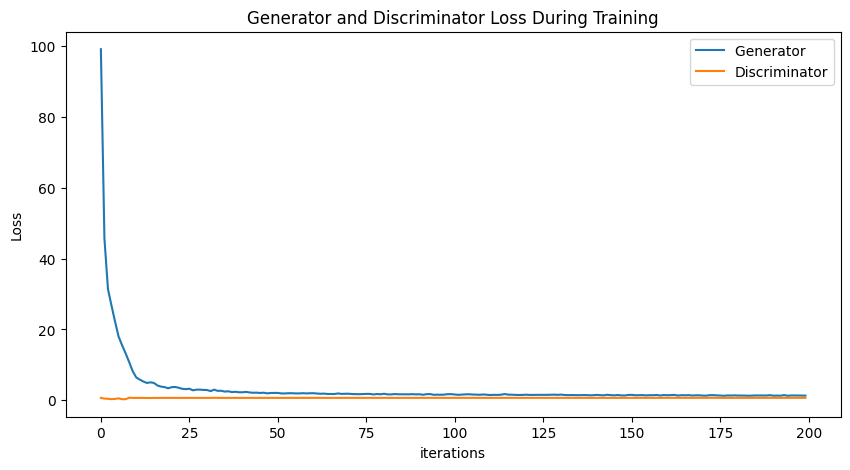

In [18]:
G_losses_plot = [i.cpu().detach().numpy() for i in G_losses]
D_losses_plot = [i.cpu().detach().numpy() for i in D_losses]
# Visualize the learning curves of the generator and discriminator
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses_plot, label="Generator ")
plt.plot(D_losses_plot, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
# plot some generated images for each digit
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])
original_mnist = datasets.MNIST(root=DATA_PATH, train=False, transform=transform, download=True)
plot_dataloader = DataLoader(original_mnist, batch_size=BATCH_SIZE, shuffle=True)

# Collect 5 examples for each specified digit
selected_images = {digit: [] for digit in range(0, 10)}
completed = False
num_examples = 5
for images, labels in plot_dataloader:
    for image, label in zip(images, labels):
        if len(selected_images[label.item()]) < num_examples:
            selected_images[label.item()].append(image.unsqueeze(0))
        if all(len(images) == num_examples for images in selected_images.values()):
            completed = True
            break
    if completed:
        # exit the loop if we have collected enough examples for each digit
        break
    
# Use the generator to generate a new image for each collected example
generated_images = {digit: [] for digit in range(0, 10)}
gen.eval()
with torch.no_grad():  # No need to track gradients
    for digit, images in selected_images.items():
        for image in images:
            # Generate an image using the generator
            # Assume the generator takes an image and the corresponding label as input
            label_tensor = torch.tensor([digit], dtype=torch.long).to(DEVICE)
            generated_image = gen(image.to(DEVICE))
            generated_images[digit].append(generated_image.cpu())

gen.train()

Generator(
  (initial_down): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, pa

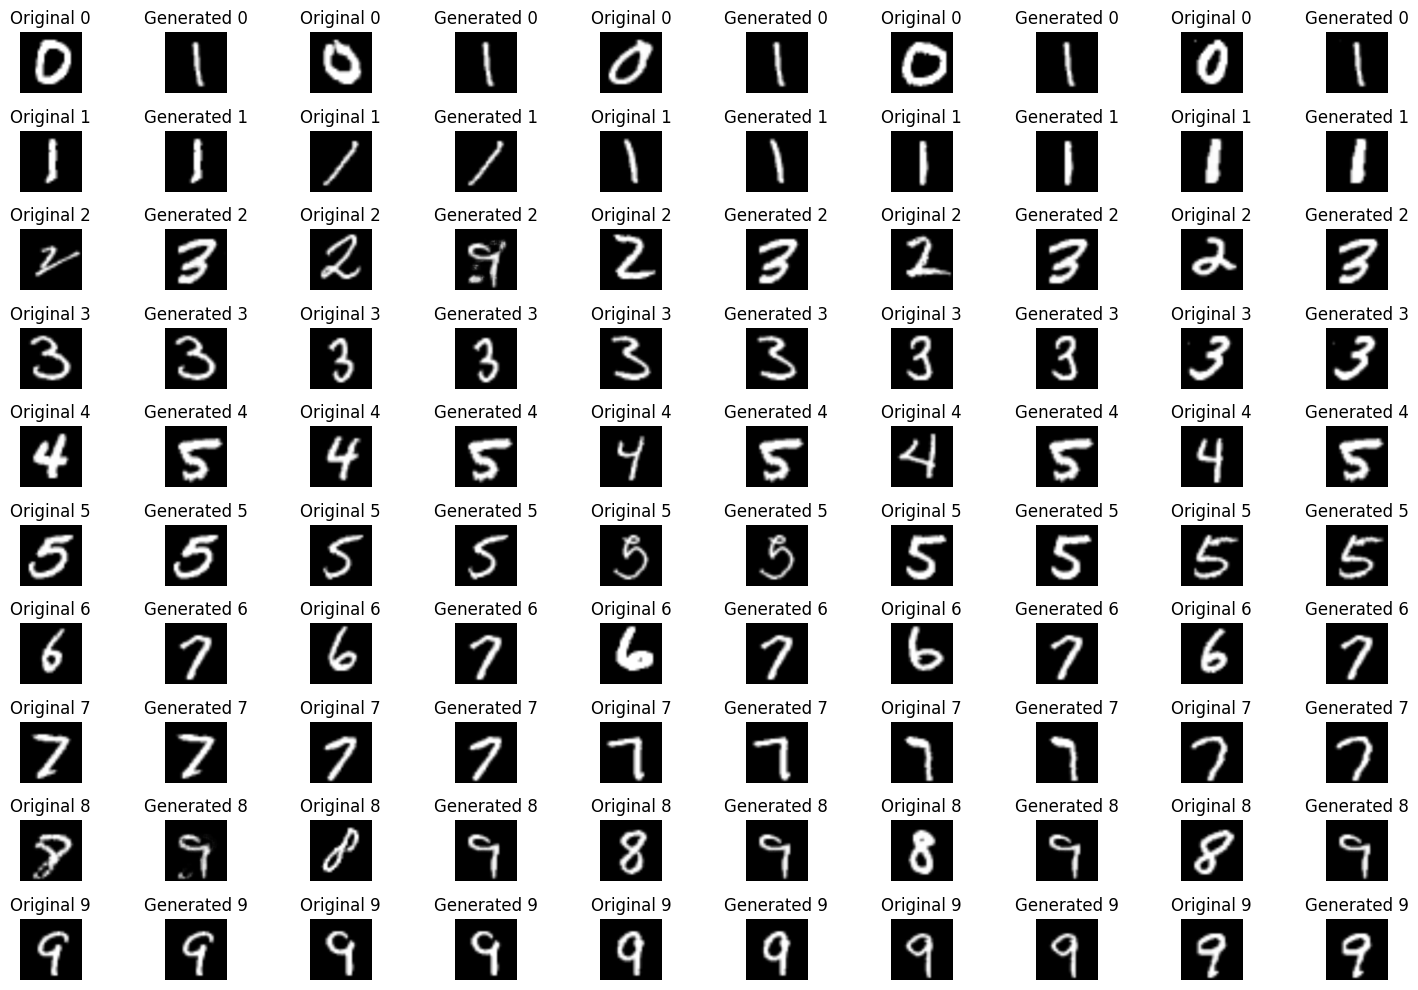

: 

In [23]:
# Plot the original and generated images
fig, axes = plt.subplots(10, num_examples * 2, figsize=(15, 10))
for i, digit in enumerate([i for i in range(0, 10)]):
    for j in range(num_examples):
        # Plot original image
        axes[i, j * 2].imshow(selected_images[digit][j].squeeze(), cmap='gray')
        axes[i, j * 2].set_title(f'Original {digit}')
        axes[i, j * 2].axis('off')

        # Plot generated image
        axes[i, j * 2 + 1].imshow(generated_images[digit][j].squeeze(), cmap='gray')
        axes[i, j * 2 + 1].set_title(f'Generated {digit}')
        axes[i, j * 2 + 1].axis('off')

plt.tight_layout()
plt.show()